# Structural window gray2018

I try to implement features on a structural window around the mutated residue for the training instances in gray2018 that have a structure. I will select the top-n contacts (by distance) and for each of them I will provide:

- sequence profile
- solvent accessibility (rsa)
- distance from the mutated position
- b factor
- some way of representing coupling
- a measure of conservation

For the mutation itself I will provide:

- aa from
- aa to
- rsa
- b factor
- evolutionary coupling (in some way)
- profile
- a measure of conservation

## Structures available and coverage

- Yap65 and gb1 do not have a structure
- PSD95pdz3 cannot produce a dssp output and has a 22.9 A resolution

In light of this I remove Yap65 and PSD95pdz3

Notes on the coverage:

- TEM: 1xpb misses only 24 residues at the N-term
- Pab1: 2 isoforms exist. The canonical has lenght 636 and the structure only covers 1-190
- KKA2: 1nd4 chains are all equivalent and cover the whole protein
- HSP90: 2cg9 covers until 677 but uniprot is 709 long, consistent gaps inside
- UBI4: 2 pdb structures exist
  - 3CMM is not in the SIFTS mappings
  - 3b0a chain D maps 533 to 684 for a sequence long 685


In light of this, I remove UBI4 and PABC1.
Lenght of the remaining proteins: TEM (286) and KKA2 (264) are comparable while HSP90 is much longer (709).
However, HSP90 has a much lower coverage so the total number of datapoint is comparable:
- Kka2     5609
- TEM-1    5397
- hsp90    4417

All the positions that have a chain ID have a PDB ID, but the reverse is not true. All the positions with a PDB ID but without a chain ID belong to the PDB ID 2cg9, the HSP90. All the HSP90 positions do not have a chain annotated. I manually set the chain to B (annotated best chain in PDBeKB).

## Mapping of IDs for reference

| Protein | Uniprot | PDB  |
|---------|---------|------|
| TEM-1   | P62593  | 1xpb |
| Kka2    | P00552  | 1nd4 |
| hsp90   | P02829  | 2cg9 |

## SIFTS mappings

The PDB ids needed where written to a file. The in-house script `pdb_get.sh` was used for downloading them from the pdb (19/03/2021). `pdb_to_dssp.sh` was used on these structures to get dssp assignments and solvent accessibility. Chains of interest where noted down next to the pdb id in a csv file. A distance matrix of the CA was obtained using the script `pdb_to_distance_matrix.sh`. The whole pdb/uniprot SIFTS mappings where downloaded and put into the dataset folder (20/03/2021). I extract only the rows of the SIFTS mappings relative to the pdb ids that interest me grepping on the id list file:

```
zcat <whole_sifts_mapping.csv> | grep -f <pdb_id_list.txt>
```

For an explanation of the meaning of the different columns of the SIFTS mapping and the database versions see the first 2 lines of the complete csv:

```
# 2021/03/15 - 03:16 | PDB: 10.21 | UniProt: 2021.02
PDB,CHAIN,SP_PRIMARY,RES_BEG,RES_END,PDB_BEG,PDB_END,SP_BEG,SP_END
```

Some notes on the columns:

- SP_PRIMARY is the Uniprot ID
- RES_BEG and RES_END refers to the ordinal numbering in the PDB file
- PDB_BEG and PDB_END refers to the resseq numbering
- SP_BEG and SP_END refers to the Uniprot numbering

What is most relevant for me is the SP_BEG and SP_END numbering, since it refers to the Uniprot numbering of the PDB positions. This field is available for all the entries. Note that there are 2 files containing SIFTS mappings. One of them contains only the extremes of the mapping ignoring gaps. The other contains the mapping for all the segments. I shall use the latter.

## Creation of the contact maps

I use custom python scripts for this and for mapping them to the uniprot sequence. I save the result in joblib dumps.

## Notes after the first experiments

On this limited dataset the use of top distances and top residues (1-hot) do not seem very helpful. However, their contribution is more significant when all the original features are considered and not only the mutation identity.
The number of residues closer than a threshold has the biggest importance. The threshold around 8 A seems optimal, but the results are not so sensitive to it (the range 8-10 seems ok). The best results where obtained using the number of residues closer than 8 A together with the 1-hot representation of the top close residues. The optimal size of the window (n top residues) is around 5, but not so sensitive ot changes. It seems fine to just ignore the mutated position itself and allow for the reporting also of residues close in primary sequence.
Now I want to implement the use of sequence profiles instead of 1-hot.

## Creation of multiple sequence alignments
I use hhblits for obtaining multiple sequence alignments against the Uniclust30 database. I use default parameters. These are 2 iterations, 0.9 maximum pairwise identity, diff 1000, and no coverage filter. If the alignments are not satisfactory, I can think to increase the minimum coverage or the maximum identity.

```
hhblits -i <input_seq> -o <result_file> -d <database> -oa3m <out_msa_file>
```

I filter for minimum 70% query coverage. I tried with a 50 and 70 threshold. The 70 threshold seems better for now visually.

```
hhfilter -i <input_a3m> -o <output_a3m> -cov 70
```

I reformat the a3m alignments to fasta using a script in the hh suite. Here I also remove the insertions in the query (`-r` parameter).

```
reformat.pl a3m fas <infile_glob> <out_ext> -r
```

## Computation of the sequence profiles

I wrote a custom scrip for obtaining sequence profiles from a fasta msa. The output is a numpy array saved in a joblib dump.

```
msa_to_profile.py -i <in_msa> -o <out_profile>
```

## Results

The most informative structural feature is the number of residues closer than 8 A from the mutated site. Identity of the neighbouring residues does not seem to be important (also as a profile), as well as their conservation or distance. It could be an issue of limited data.
MSA seem very informative for the mutated position. No much importance on the parameters used for filtering the msa. Default params with minimum coverage of 0.7 and removing query gaps works well. The log ratio of the profile entries for aa1 and aa2 in the mutated position is informative.
Could try now to cluster the profiles according to chemo-physical properties and repeat.


## Loading of the default dataset

In [35]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, MaxAbsScaler, QuantileTransformer
from sklearn.utils import class_weight
import joblib
from Bio import SeqIO

df = pd.read_csv('../dataset/gray2018/dmsTraining_2017-02-20.csv')

# some of the studies in the training set were excluded from training in the original paper
# I also remove here proteins without a structure
excluded_studies = ['Brca1_E3', 'Brca1_Y2H', 'E3_ligase']
for study in excluded_studies:
    df = df[df.dms_id != study]
    
# I also remove here proteins without a structure
without_structure = ['Yap65', 'gb1']
# or that do not give a dssp output
no_dssp = ['PSD95pdz3']
# or whose structure is very bad/low coverage
low_coverage = ['UBI4', 'Pab1']

for protein in without_structure+no_dssp+low_coverage:
    df = df[df.protein != protein]

# obtain a dictionary with the uniprot sequences for each protein
sequences = {}
for basename in set(df.uniprot_id):
    curr_seq = str(list(SeqIO.parse('../processing/gray2018/structural_window/uniprot_sequences/' + basename + '.fasta', 'fasta'))[0].seq)
    sequences[basename] = curr_seq

len_before = len(df)
        
# remove inconsistencies with the uniprot sequences
index_in_range = pd.Series([row.position - 1 < len(sequences[row.uniprot_id]) for _, row in df.iterrows()], index=df.index)
df = df[index_in_range]
correct_aa1 = pd.Series([row.aa1 == sequences[row.uniprot_id][row.position - 1] for _, row in df.iterrows()], index=df.index)
df = df[correct_aa1]

# check that there are no more inconsistencies
for protein in set(df.uniprot_id.values):
    curr_df = df[df.uniprot_id == protein]
    for position in set(curr_df.position.values):
        aa1_set = set(curr_df[curr_df.position == position].aa1)
        assert len(aa1_set) == 1
        curr_aa1 = aa1_set.pop()
        seq_index = position - 1
        curr_real_res = sequences[protein][seq_index]
        assert curr_aa1 == curr_real_res
                
# print how many entries have been removed (the false values)
len_after = len(df)
print('Removed entries for wrong mapping:', len_before - len_after)

# assigning the missing chain to hsp90
assert df[(df.pdb_id == '2cg9')].pdb_chain_id.isna().all()
assert not df[(df.pdb_id != '2cg9') & ~df.pdb_id.isna()].pdb_chain_id.isna().all()
df.loc[df.pdb_id == '2cg9', 'pdb_chain_id'] = 'B'

# remove positions with missing representation in the PDB
len_before = len(df)
df = df[~df.pdb_id.isna()]
len_after = len(df)
print('Removed entries for missing PDB representation:', len_before - len_after)

# this df will contain different normalizations of the outputs, and pointers to the protein and dataset of origin
effect_df = pd.DataFrame({'protein': df.protein,
                          'dms_id': df.dms_id,
                          'position': df.position,
                          'aa1': df.aa1,
                          'aa2': df.aa2,
                          'uniprot_id': df.uniprot_id,
                          'pdb_id': df.pdb_id,
                          'pdb_chain_id': df.pdb_chain_id,
                          'reported_fitness': df.reported_fitness,
                          'scaled_effect1': df.scaled_effect1})

# scale the maximum positive and negative effects to 1 and -1 without moving the 0
for dataset in set(effect_df.dms_id):
    curr_df = effect_df[effect_df.dms_id == dataset]
    x_neg = np.array(curr_df[curr_df.reported_fitness <= 0].reported_fitness).reshape(-1,1)
    x_pos = np.array(curr_df[curr_df.reported_fitness >= 0].reported_fitness).reshape(-1,1)
    scaler = MinMaxScaler()
    x_neg_scaled, x_pos_scaled = -scaler.fit_transform(-x_neg), scaler.fit_transform(x_pos)
    effect_df.loc[(effect_df.dms_id == dataset) & (effect_df.reported_fitness >= 0) , 'scaled_effect2'] = x_pos_scaled
    effect_df.loc[(effect_df.dms_id == dataset) & (effect_df.reported_fitness <= 0) , 'scaled_effect2'] = x_neg_scaled

# scale the maximum absolute value to 1, without moving the 0
for dataset in set(effect_df.dms_id):
    curr_df = effect_df[effect_df.dms_id == dataset]
    scaler = MaxAbsScaler()
    x = np.array(curr_df.reported_fitness).reshape(-1,1)
    x_scaled = scaler.fit_transform(x)
    effect_df.loc[(effect_df.dms_id == dataset) , 'scaled_effect3'] = x_scaled

# make the distribution uniform (basically uses ranks)
for dataset in set(effect_df.dms_id):
    curr_df = effect_df[effect_df.dms_id == dataset]
    scaler = QuantileTransformer(n_quantiles=100)
    x = np.array(curr_df.reported_fitness).reshape(-1,1)
    x_scaled = scaler.fit_transform(x)
    effect_df.loc[(effect_df.dms_id == dataset) , 'scaled_effect4'] = x_scaled
    
# make the distribution normal
for dataset in set(effect_df.dms_id):
    curr_df = effect_df[effect_df.dms_id == dataset]
    scaler = QuantileTransformer(output_distribution='normal', n_quantiles=100)
    x = np.array(curr_df.reported_fitness).reshape(-1,1)
    x_scaled = scaler.fit_transform(x)
    effect_df.loc[(effect_df.dms_id == dataset) , 'scaled_effect5'] = x_scaled
    
# make the distribution uniform (basically uses ranks) but separately for positive and negative values
for dataset in set(effect_df.dms_id):
    curr_df = effect_df[effect_df.dms_id == dataset]
    x_neg = np.array(curr_df[curr_df.reported_fitness <= 0].reported_fitness).reshape(-1,1)
    x_pos = np.array(curr_df[curr_df.reported_fitness >= 0].reported_fitness).reshape(-1,1)
    scaler = QuantileTransformer(n_quantiles=100)
    x_neg_scaled, x_pos_scaled = -scaler.fit_transform(-x_neg), scaler.fit_transform(x_pos)
    effect_df.loc[(effect_df.dms_id == dataset) & (effect_df.reported_fitness >= 0) , 'scaled_effect6'] = x_pos_scaled
    effect_df.loc[(effect_df.dms_id == dataset) & (effect_df.reported_fitness <= 0) , 'scaled_effect6'] = x_neg_scaled
    
# make the distribution uniform (basically uses ranks) but crop everything positive to 0
for dataset in set(effect_df.dms_id):
    curr_df = effect_df[effect_df.dms_id == dataset]
    scaler = QuantileTransformer(n_quantiles=100)
    x = np.array(curr_df.reported_fitness).reshape(-1,1)
    # replace positive values with 0
    x[x > 0] = 0
    x_scaled = scaler.fit_transform(-x)
    effect_df.loc[(effect_df.dms_id == dataset) , 'scaled_effect7'] = x_scaled

# quantile normalization with removal of the wt score
# the idea was taken from Munro2020
for dataset in set(effect_df.dms_id):
    curr_df = effect_df[effect_df.dms_id == dataset]
    scaler = QuantileTransformer(n_quantiles=100)
    x = np.array(curr_df.reported_fitness).reshape(-1,1)
    x_scaled = scaler.fit_transform(x) - scaler.transform(np.zeros((1,1)))
    effect_df.loc[(effect_df.dms_id == dataset) , 'scaled_effect8'] = x_scaled
    
# random output for testing
effect_df['random_effect'] = np.random.permutation(effect_df.scaled_effect8)

# separate numerical and categorical features
is_feature = ['aa1',
              'aa2',
              'WT_Mut', 
              'aa1_polarity',
              'aa2_polarity',
              'aa1_PI', 
              'aa2_PI',
              'deltaPI', 
              'aa1_weight',
              'aa2_weight', 
              'deltaWeight', 
              'aa1vol', 
              'aa2vol', 
              'deltavolume',
              'Grantham', 
              'aa1_psic', 
              'aa2_psic', 
              'delta_psic', 
              'accessibility',
              'dssp_sec_str', 
              'phi_psi_reg', 
              'delta_solvent_accessibility',
              'b_factor', 
              'mut_msa_congruency',
              'mut_mut_msa_congruency',
              'selection_coefficient',
              'evolutionary_coupling_avg', 
              'evolutionary_coupling_prop',
              'evolutionary_coupling_avg_norm']

is_categorical_feature = ['aa1',
                          'aa2',
                          'aa1_polarity',
                          'aa2_polarity',
                          'WT_Mut', 
                          'dssp_sec_str',
                          'phi_psi_reg', 
                         ]

is_numerical_feature = [feature for feature in is_feature if feature not in is_categorical_feature]

x_numerical_list = []
x_numerical_feature_names_list = []
for column in df[is_numerical_feature]:
    x_numerical_list.append(df[column])
    x_numerical_feature_names_list.append(column)
x_numerical = np.array(x_numerical_list).T
x_numerical_feature_names = np.array(x_numerical_feature_names_list).T

# categorical to one-hot encoding
x_categorical = np.array(df[is_categorical_feature])
enc = OneHotEncoder(sparse=False)
to_concat = []
to_concat_feature_names = []
for column, name in zip(x_categorical.T, is_categorical_feature):
    column_one_hot = enc.fit_transform(column.reshape(-1,1))
    to_concat.append(column_one_hot)
    to_concat_feature_names.append(np.array([name + '_onehot_dim_' + str(i) for i in range(column_one_hot.shape[1])]))
x_onehot = np.concatenate(to_concat, axis=1)
x_onehot_feature_names = np.concatenate(to_concat_feature_names)

x_naive = np.concatenate([x_onehot, x_numerical], axis=1)
x_naive_feature_names = np.concatenate([x_onehot_feature_names, x_numerical_feature_names])

x_naive.shape, len(effect_df), len(df)

Removed entries for wrong mapping: 39
Removed entries for missing PDB representation: 656


((14767, 513), 14767, 14767)

## Addition of custom features

In [36]:
from Bio.Data.IUPACData import extended_protein_letters
from scipy import stats
import itertools

# encoder for aa1 and aa2
enc = OneHotEncoder(sparse=False)
enc.fit(np.array(list(extended_protein_letters + '-')).reshape(-1,1))

# create a lookup table with the features for faster access
c_map_lookup_table = dict()
window_size = 1
ignore_closer_than = -1
distance_threshold = 8
for pdb_id in set(effect_df.pdb_id):
    c_map_lookup_table[pdb_id] = dict()
    for chain_id in set(effect_df[effect_df.pdb_id == pdb_id].pdb_chain_id):
        uniprot_id_set = set(effect_df[(effect_df.pdb_id == pdb_id) & (effect_df.pdb_chain_id == chain_id)].uniprot_id)
        assert len(uniprot_id_set) == 1
        uniprot_id = uniprot_id_set.pop()
        c_map_dict = joblib.load('../processing/gray2018/structural_window/distance_matrix/' + pdb_id + '.uniprot_distance_matrix.joblib.xz')
        c_map_lookup_table[pdb_id][chain_id] = dict()
        c_map_lookup_table[pdb_id][chain_id]['uniprot_seq'] = c_map_dict['uniprot_seq']
        c_map_lookup_table[pdb_id][chain_id]['profile'] = joblib.load(
            '../processing/gray2018/structural_window/hhblits_msa/default_params/hhfilter_cov_70/' + uniprot_id + '.profile.joblib.xz')['profile'].T
        c_map_lookup_table[pdb_id][chain_id]['profile_residue_order'] = joblib.load(
            '../processing/gray2018/structural_window/hhblits_msa/default_params/hhfilter_cov_70/' + uniprot_id + '.profile.joblib.xz')['residue_order']
        c_map_lookup_table[pdb_id][chain_id]['shannon'] = stats.entropy(c_map_lookup_table[pdb_id][chain_id]['profile'], axis=1)
        c_map_lookup_table[pdb_id][chain_id]['positions'] = list()
        assert np.all(enc.categories_ == c_map_lookup_table[pdb_id][chain_id]['profile_residue_order'])
        for i, contact_vec in enumerate(c_map_dict['distance_matrix']):
            c_map_lookup_table[pdb_id][chain_id]['positions'].append(dict())
            argsort = np.argsort(contact_vec) # get index of sorted elements (nan is last)
            sorted_indexes = argsort[np.logical_not(np.isnan(contact_vec[argsort]))] # remove indexes that point to nan
            sorted_indexes = sorted_indexes[abs(sorted_indexes - i) > ignore_closer_than]
            c_map_lookup_table[pdb_id][chain_id]['positions'][i]['sorted_indexes'] = sorted_indexes
            c_map_lookup_table[pdb_id][chain_id]['positions'][i]['sorted_distances'] = contact_vec[sorted_indexes]

# create the array of features using the lookup table
empty_top_residues = np.array([np.nan]*len(extended_protein_letters) * window_size)
empty_top_profiles = np.array([np.nan]*len(extended_protein_letters + '-') * window_size)
empty_top_shannon = np.array([np.nan]*window_size)


x_structural_window = []
for _, row in effect_df.iterrows():
    chain_table = c_map_lookup_table[row.pdb_id][row.pdb_chain_id]
    sorted_indexes = chain_table['positions'][row.position - 1]['sorted_indexes']
    sorted_distances = chain_table['positions'][row.position - 1]['sorted_distances']
    
    # mutation likelyhood
    assert row.aa1 == chain_table['uniprot_seq'][row.position - 1]
    aa1_1hot = enc.transform(np.expand_dims(row.aa1, axis = (0,1))).flatten()
    aa2_1hot = enc.transform(np.expand_dims(row.aa2, axis = (0,1))).flatten()
    mut_pos_profile = chain_table['profile'][row.position -1].flatten()
    aa1_likelyhood = np.expand_dims((mut_pos_profile * aa1_1hot).sum(), axis=0)
    aa2_likelyhood = np.expand_dims((mut_pos_profile * aa2_1hot).sum(), axis=0)
    delta_likelyhood = np.log((aa1_likelyhood + 1e-5)) - np.log((aa2_likelyhood + 1e-5))
    
    # structural features
    if len(sorted_indexes) > 0:
        sorted_residues_onehot = enc.transform(chain_table['uniprot_seq'][sorted_indexes].reshape(-1,1))
        top_residues = sorted_residues_onehot[:window_size].flatten()
    else:
        top_residues = empty_top_residues
    if len(sorted_indexes) > 0:
        sorted_profiles = chain_table['profile'][sorted_indexes]
        top_profiles = sorted_profiles[:window_size].flatten()
    else:
        top_profiles = empty_top_profiles
    if len(sorted_indexes) > 0:
        sorted_shannon = chain_table['shannon'][sorted_indexes]
        top_shannon = sorted_shannon[:window_size]
    else:
        top_shannon_cov70 = empty_top_shannon
    if len(sorted_distances) > 0:
        top_distances = sorted_distances[:window_size]
    else:
        top_distances = np.array([np.nan] * window_size)
    if len(sorted_distances) > 0:
        n_close_res = np.expand_dims((sorted_distances < distance_threshold).sum(), axis=0)
    else:
        n_close_res = np.expand_dims(np.nan, axis=0)
        
    # compile the features
    curr_row = np.concatenate([n_close_res, mut_pos_profile, delta_likelyhood, aa1_likelyhood, aa2_likelyhood])
    #curr_row = n_close_res
    x_structural_window.append(curr_row)
x_structural_window = np.array(x_structural_window)

# add the structural features (non permutated) to the naive features
x = np.concatenate([x_naive, x_structural_window.reshape(x_structural_window.shape[0], -1)], axis=1)

x_structural_window.shape, x.shape, x_naive.shape, effect_df.shape

((14767, 31), (14767, 544), (14767, 513), (14767, 18))

## Permuatation of the structural features (experimental)

This causes very high memory consumption without improving the results

### Create the model

In [37]:
import numpy as np
import pandas as pd; pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from scipy import stats
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import LeaveOneGroupOut, RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.impute import SimpleImputer
import joblib


def lopo_plots_and_correlation(x, df, target):
    y = np.array(df[target])
    regr = RandomForestRegressor(n_jobs=-1, bootstrap=True, oob_score=False, n_estimators=100, verbose=0, random_state=1)
    lopo = LeaveOneGroupOut()
    max_spearman, min_spearman = -100, 100 # reversed since I want them to be updated
    max_pearson, min_pearson = -100, 100
    results = []
    for train, val in lopo.split(x, groups=df.protein):
        curr_protein_tested = list(set(df.protein.iloc[val]))
        assert len(curr_protein_tested) == 1
        print('Protein:', curr_protein_tested[0])
        imp = SimpleImputer()
        imp.fit(x[train])
        x_imputed = imp.transform(x)
        regr.fit(x_imputed[train], y[train])
        y_pred = regr.predict(x_imputed[val])
        for dataset in list(set(df.dms_id.iloc[val])):
            print('Dataset:', dataset)
            y_pred_to_show, y_test_to_show = y_pred[df.dms_id.iloc[val] == dataset].flatten(), y[val][df.dms_id.iloc[val] == dataset].flatten()
            curr_spearman = stats.spearmanr(y_pred_to_show, y_test_to_show)[0]
            max_spearman, min_spearman = max(max_spearman, curr_spearman), min(min_spearman, curr_spearman)
            results.append([dataset, curr_spearman, [y_pred_to_show, y_test_to_show]])
            print('spearman:', curr_spearman)           
            plt.close()
            sns.scatterplot(x=y_test_to_show, y=y_pred_to_show, s=10)
            plt.show()           
    print('Overall min spearman:', min_spearman, '\nOverall max spearman', max_spearman)
    result = pd.DataFrame(results, columns=['dataset', 'spearman', 'full_results'])
    return results

### Train and validate

Protein: Kka2
Dataset: kka2_1:2
spearman: 0.6658736259912837


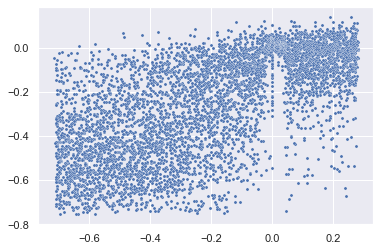

Protein: TEM-1
Dataset: beta-lactamase
spearman: 0.753946799773469


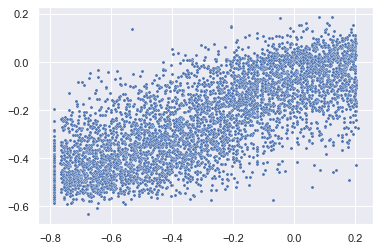

Protein: hsp90
Dataset: hsp90
spearman: 0.3420717948211674


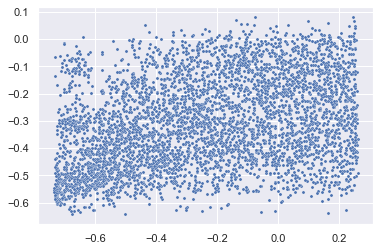

Overall min spearman: 0.3420717948211674 
Overall max spearman 0.753946799773469


In [39]:
results = lopo_plots_and_correlation(x, effect_df, 'scaled_effect8')

## Random forest with original features
I want to see what performances random forest gets with the original features used in gray2018 on this reduced dataset.

Protein: Kka2
Dataset: kka2_1:2
spearman: 0.6715583151748944


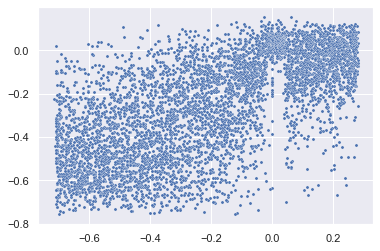

Protein: TEM-1
Dataset: beta-lactamase
spearman: 0.7159893916902151


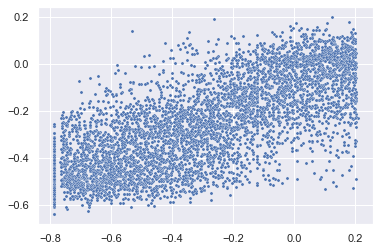

Protein: hsp90
Dataset: hsp90
spearman: 0.2737270401611139


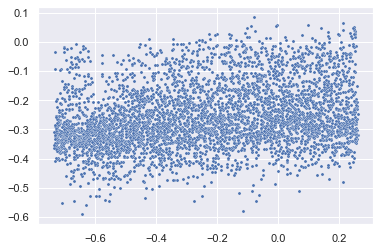

Overall min spearman: 0.2737270401611139 
Overall max spearman 0.7159893916902151


In [38]:
results = lopo_plots_and_correlation(x_naive, effect_df, 'scaled_effect8')